In [115]:
import pandas as pd
import numpy as np
from ISLP import load_data
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR, plot_tree, export_text)
from sklearn.metrics import (accuracy_score, log_loss)
from ISLP import confusion_table
from sklearn.model_selection import cross_val_score

In [116]:
OJ = load_data("OJ")
#OJ['Purchase'] = OJ.Purchase.map(dict(CH=1,MM=0))
OJ['Store7'] = OJ.Store7.map(dict(Yes=1,No=0))
OJ.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,0,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,0,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,0,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,0,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,1,0.000000,0.000000,0.00,0


In [117]:
# Initalizing variables
model = MS(OJ.columns.drop('Purchase'), intercept=False)
D = model.fit_transform(OJ)
feature_names = list(D.columns)
X = np.asarray(D)

# Part A
X_train, X_test, y_train, y_test = skm.train_test_split(X,
                                                        OJ['Purchase'],
                                                        test_size=270,
                                                        random_state=1)


In [118]:
# Part B
clf = DTC(criterion='entropy', # whether to use Gini or cross-entropy as split criterion
          max_depth=3,
          random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [119]:
accuracy_score(y_train, clf.predict(X_train))
# Train accuracy rate

0.8325

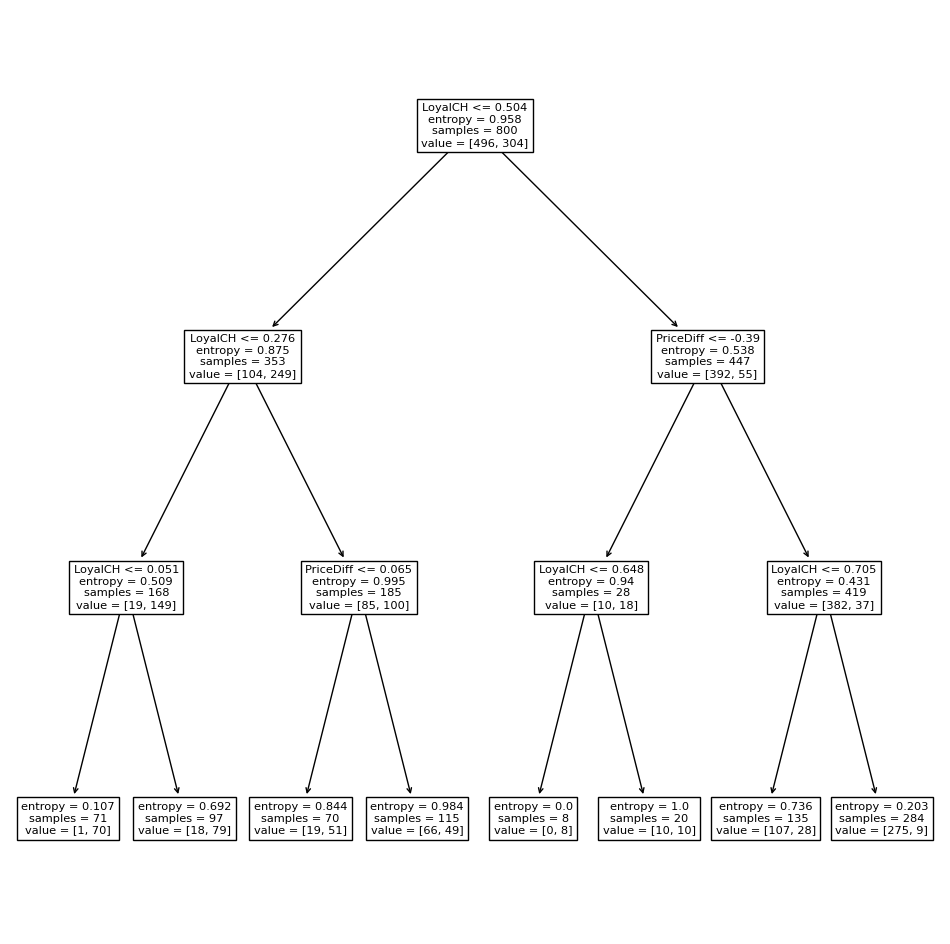

In [120]:
# Part C
ax = subplots(figsize=(12,12))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax);
# Note that we mostly used LoyalCH as a predictor, and price snuck its way in there as well ( 8 terminal nodes)

In [121]:
# Part D
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))
# Looking at the first node that classifies a person to MM we see that 
# If they're loyaCH <- 0.28 then they're likely going to buy MM
# We can look one node up since both adjacent terminal nodes give the same output

|--- LoyalCH <= 0.50
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.05
|   |   |   |--- weights: [1.00, 70.00] class: MM
|   |   |--- LoyalCH >  0.05
|   |   |   |--- weights: [18.00, 79.00] class: MM
|   |--- LoyalCH >  0.28
|   |   |--- PriceDiff <= 0.07
|   |   |   |--- weights: [19.00, 51.00] class: MM
|   |   |--- PriceDiff >  0.07
|   |   |   |--- weights: [66.00, 49.00] class: CH
|--- LoyalCH >  0.50
|   |--- PriceDiff <= -0.39
|   |   |--- LoyalCH <= 0.65
|   |   |   |--- weights: [0.00, 8.00] class: MM
|   |   |--- LoyalCH >  0.65
|   |   |   |--- weights: [10.00, 10.00] class: CH
|   |--- PriceDiff >  -0.39
|   |   |--- LoyalCH <= 0.71
|   |   |   |--- weights: [107.00, 28.00] class: CH
|   |   |--- LoyalCH >  0.71
|   |   |   |--- weights: [275.00, 9.00] class: CH



In [122]:
# Part E
# Test accuracy rate
accuracy_score(y_test, clf.predict(X_test))

0.8296296296296296

In [123]:
confusion_table(y_test, clf.predict(X_test))

Truth,CH,MM
Predicted,,
CH,146,11
MM,35,78


In [124]:
# Part F

# Using CV to determine best max_depth
cv_scores = []
for depth in range(2,15):
    clf = DTC(criterion='entropy', # whether to use Gini or cross-entropy as split criterion
          max_depth=depth,
          random_state=0)
    clf.fit(X_train, y_train)
    cv_scores.append(1-np.mean(cross_val_score(clf, X_train, y_train, cv=5)))
cv_scores
# The best depth by train CV is depth 4

[0.20625000000000004,
 0.21499999999999997,
 0.19124999999999992,
 0.20625000000000004,
 0.20124999999999993,
 0.2124999999999999,
 0.21875,
 0.21999999999999997,
 0.23375,
 0.235,
 0.22750000000000004,
 0.24,
 0.23750000000000004]

In [2]:
# Part G
ax = subplots(figsize=(8,8))[1]
ax.plot(range(2,15),
        cv_scores,
        'b');
ax.set_ylabel('Test CV error', fontsize=20);
ax.set_xlabel('Max depth of tree', fontsize=20);

NameError: name 'subplots' is not defined

In [126]:
# Part H, lowest cv is depth 4

In [145]:
# Part I

# Get the cost-complexity values
ccp_path = clf.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(13,  
                  random_state=0,
                  shuffle=True)

In [146]:
# Getting optimal tree via cross-validation
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                         refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, y_train)
grid.best_score_

0.8100109831997723

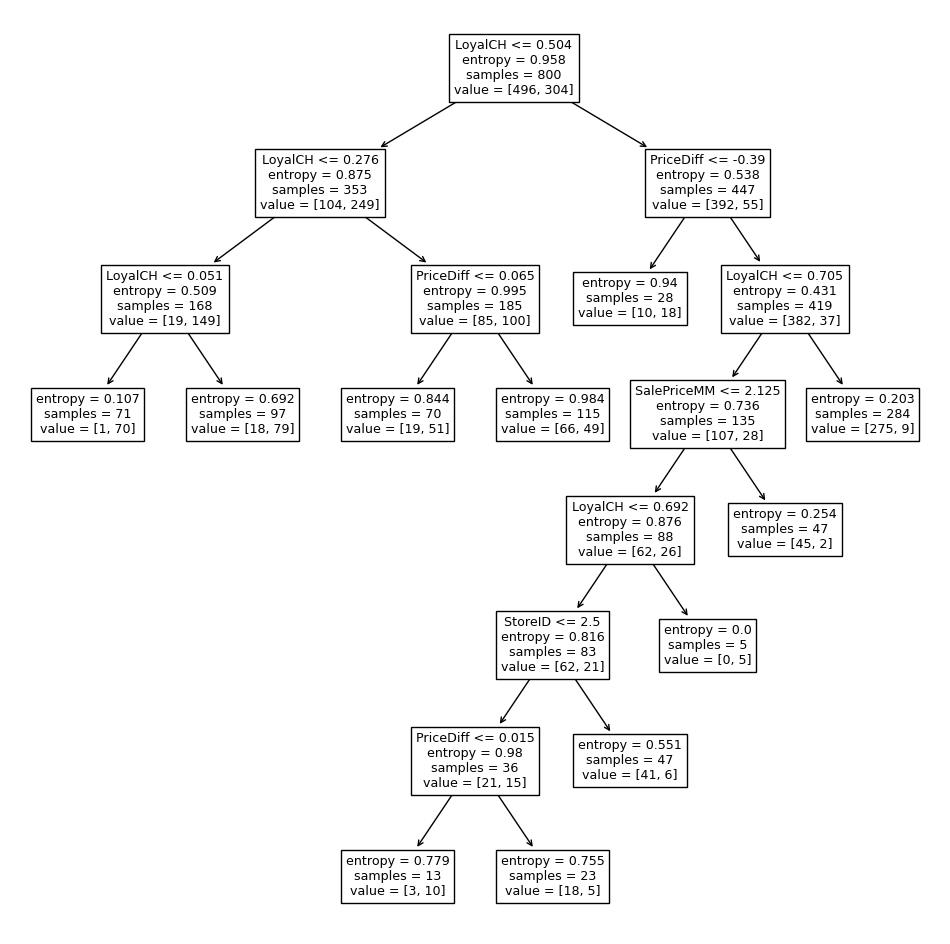

In [147]:
# Plotting pruned tree
ax = subplots(figsize=(12,12))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,
          ax=ax);
# Notice that only one node was taken out

In [148]:
best_ = grid.best_estimator_
print("Train score: " , accuracy_score(y_train, best_.predict(X_train)))
print("Test score : ", accuracy_score(y_test, best_.predict(X_test)))

Train score:  0.8475
Test score :  0.8222222222222222


In [135]:
# The pruned tree had higher train score with lower test score, most likely due to overfitting